# SkimLit

NLP model to make reading medical abstracts easier.

To do this, we will implement the deep learning model described in https://arxiv.org/pdf/1612.05251.pdf

Project done on Google Colab (Tesla T4)

## Import required libraries

In [ ]:
import os
import string
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import matplotlib.pyplot as plt

## Get the data

The data is publicly available on GitHub so let's download it.

In [ ]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct
!ls pubmed-rct

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 30, done.
remote: Total 30 (delta 0), reused 0 (delta 0), pack-reused 30
Unpacking objects: 100% (30/30), done.
PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
README.md


In [ ]:
!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/

dev.txt  test.txt  train.txt


In order to have short computing times, we will use the PubMed_20k_RCT dataset, which is a subset (10%) of the original dataset.

In [ ]:
# Let's start working on the smaller dataset (20k instead of 200k)
data_dir = "/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"

In [ ]:
filenames = [data_dir + filename for filename in os.listdir(data_dir)]
filenames

['/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt']

## Preprocess the data

For the deep learning model to run, we will need to transform text into numbers. Hovewer, before this preprocessing step, let's see what the data look like.

In [ ]:
# Create function to read text
def get_lines(filename):
  """
  Reads filename and returns the lines as a list.

  Args:
    filename: path to text file.

  Returns:
    A list of strings with one string per line.
  """
  with open(filename, "r") as ifs:
    return ifs.readlines()

In [ ]:
# Read train file
train_lines = get_lines(data_dir + "train.txt")
train_lines[:20]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

We therefore need to separate the target labels (BACKGROUND, OBJECTIVE, etc.) from the text.

In [ ]:
def preprocess_text_with_line_numbers(filename):
  """
  Returns a list of dictionaries containing abstract data.
  """
  input_lines = get_lines(filename)
  abstract_lines = ""
  abstract_samples = []

  for line in input_lines:
    if line.startswith("###"): # The id of the abstract
      abstract_id = line
      abstract_lines = ""
    elif line.isspace(): # On a new line?
      abstract_lines_split = abstract_lines.splitlines()
      for abstract_line_number, abstract_line in enumerate(abstract_lines_split):
        line_data = {}
        target_text_split = abstract_line.split("\t")
        line_data["target"] = target_text_split[0]
        line_data["text"] = target_text_split[1].lower()
        line_data["line_number"] = abstract_line_number
        line_data["total_lines"] = len(abstract_lines_split) - 1
        # Append dictionary
        abstract_samples.append(line_data)
    else:
      abstract_lines += line

  return abstract_samples

In [ ]:
train_samples = preprocess_text_with_line_numbers(data_dir + "train.txt")
val_samples = preprocess_text_with_line_numbers(data_dir + "dev.txt")
test_samples = preprocess_text_with_line_numbers(data_dir + "test.txt")

In [ ]:
train_samples[:2]

[{'line_number': 0,
  'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'total_lines': 11},
 {'line_number': 1,
  'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'total_lines': 11}]

Let's turn the data into dataframes

In [ ]:
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)

In [ ]:
train_df.head()

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11


In [ ]:
# Distribution of data
train_df["target"].value_counts()

METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: target, dtype: int64

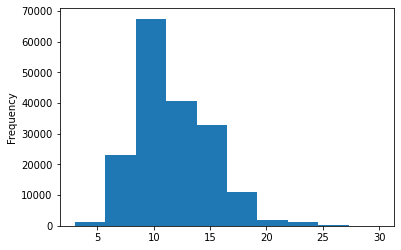

In [ ]:
# Distribution of line lengths
train_df["total_lines"].plot.hist()

### Get lists of sentences

In [ ]:
# Convert the lines into lists
train_sentences = train_df["text"].tolist()
val_sentences = val_df["text"].tolist()
test_sentences = test_df["text"].tolist()

In [ ]:
train_sentences[:10]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

## Make numeric labels

In [ ]:
# One hot encode labels
one_hot_encoder = OneHotEncoder(sparse=False)
train_labels_one_hot = one_hot_encoder.fit_transform(train_df["target"].to_numpy().reshape(-1, 1))
val_labels_one_hot = one_hot_encoder.transform(val_df["target"].to_numpy().reshape(-1, 1))
test_labels_one_hot = one_hot_encoder.transform(test_df["target"].to_numpy().reshape(-1, 1))

In [ ]:
# Label encode
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df["target"].to_numpy())
val_labels_encoded = label_encoder.transform(val_df["target"].to_numpy())
test_labels_encoded = label_encoder.transform(test_df["target"].to_numpy())

In [ ]:
# Check one-hot-encoded labels
train_labels_one_hot

array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [ ]:
# Check label-encoded labels
train_labels_encoded

array([3, 2, 2, ..., 4, 1, 1])

In [ ]:
# Get class names back from labels
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_
num_classes, class_names

(5, array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

## Prepare our data for deep learning

Create vectorization and embedding layers.

In [ ]:
# Let's look at average sentence length
sent_len = [len(sentence.split()) for sentence in train_sentences]
avg_sent_len = np.mean(sent_len)
avg_sent_len

In [ ]:
# Distribution length
plt.hist(sent_len, bins=50);

In [ ]:
# For the cuoff value we will take the 95 percentile of the distribution
np.percentile(sent_len, q=95)

### Create text vectorizer layer

In [ ]:
max_tokens = 68000 # from paper
text_vectorizer = TextVectorization(max_tokens=max_tokens,
                                    output_sequence_length=55) # 95 percentile above

In [ ]:
# Adapt vectorizer to training sentences
text_vectorizer.adapt(train_sentences)

In [ ]:
rct_20k_text_vocab = text_vectorizer.get_vocabulary()
print(len(rct_20k_text_vocab))
print("Five most common:", rct_20k_text_vocab[:5])

### Create text embedding

In [ ]:
token_embed = layers.Embedding(input_dim=len(rct_20k_text_vocab),
                               output_dim=128, # Dimension of embedding output
                               mask_zero=True, # For variable sequence length,
                               name="token_embedding")

**Actually**

We will use a pretrained embedding layer
from https://tfhub.dev/google/universal-sentence-encoder/4

NOTE: USE takes care of tokenization for us.



In [ ]:
# Download pretrained TensorFlow Hub Universal Sentence Encoder (USE)
tf_hub_embedding_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        trainable=False,
                                        name="universal_sentence_encoder")

### Create character vectorizer

In [ ]:
# Define function to split sentences into characters
def split_chars(text):
  return " ".join(list(text))

In [ ]:
# Apply function to entire dataset
train_chars = [split_chars(sentence) for sentence in train_sentences]
val_chars = [split_chars(sentence) for sentence in val_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]
train_chars[:10]

In [ ]:
# Average character length
char_lens = [len(sentence) for sentence in train_sentences]
np.mean(char_lens)

In [ ]:
plt.hist(char_lens, bins=100);

In [ ]:
output_seq_char_len = int(np.percentile(char_lens, 95))
output_seq_char_len

In [ ]:
alphabet = string.ascii_lowercase + string.digits + string.punctuation
alphabet

In [ ]:
# OOV = out of vocabulary (=unkwown)
# Create char-level token vectorizer
NUM_CHAR_TOKENS = len(alphabet) + 2 # add 2 for space and OOV token
char_vectorizer = TextVectorization(max_tokens=NUM_CHAR_TOKENS,
                                    output_sequence_length=output_seq_char_len,
                                    name="char_vectorizer")

In [ ]:
# Adapt character vectorizer to training character
char_vectorizer.adapt(train_chars)

In [ ]:
char_vocab = char_vectorizer.get_vocabulary()
print(f"Number of different characters: {len(char_vocab)}")

### Creating a character-level embedding

In [ ]:
# Create character-level embedding layer
char_embed = layers.Embedding(input_dim=NUM_CHAR_TOKENS,
                              output_dim=25, # From paper
                              mask_zero=True,
                              name="char_embed")

## Adding line numbers and lengths (Positional Embeddings)

We'll add the line number and the total number of lines to the set of features (positional embedding).

In [ ]:
# Let's look at distribution of line_number
train_df["line_number"].hist(bins=30)

Majority of lines have position < 15. So let's use 15 as the depth parameter when one-hot encoding.

In [ ]:
# Use Tensorflow to one-hot encode line_number
train_line_numbers_one_hot = tf.one_hot(train_df["line_number"].to_numpy(), depth=15)
val_line_numbers_one_hot = tf.one_hot(val_df["line_number"].to_numpy(), depth=15)
test_line_numbers_one_hot = tf.one_hot(test_df["line_number"].to_numpy(), depth=15)
train_line_numbers_one_hot[:5]

In [ ]:
# Let's look at distribution of total_lines
train_df["total_lines"].hist(bins=25)

A value of 20 seems to cover the majority of samples. Let's use this when hot-encoding.

In [ ]:
# Use Tensorflow to one-hot encode total_lines
train_total_lines_one_hot = tf.one_hot(train_df["total_lines"].to_numpy(), depth=20)
val_total_lines_one_hot = tf.one_hot(val_df["total_lines"].to_numpy(), depth=20)
test_total_lines_one_hot = tf.one_hot(test_df["total_lines"].to_numpy(), depth=20)
train_total_lines_one_hot[:5]

### Building the model

Pretrained token embedding + character embedding + positional embedding

In [ ]:
# 1. Create a token-level model
token_inputs = layers.Input(shape=[], dtype=tf.string, name="token_inputs")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_outputs = layers.Dense(128, activation="relu")(token_embeddings)
# NOTE: token_outputs doesn't seem to be used!
token_model = tf.keras.Model(inputs=token_inputs,
                             outputs=token_embeddings)
                            #  outputs=token_outputs)

# 2. Create a character-level model
char_inputs = layers.Input(shape=(1, ), dtype=tf.string, name="char_inputs")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(32))(char_embeddings)
char_model = tf.keras.Model(inputs=char_inputs,
                            outputs=char_bi_lstm)

# 3. Create model for line_number
line_number_inputs = layers.Input(shape=(15,), dtype=tf.float32, name="line_number_inputs")
line_number_outputs = layers.Dense(32, activation="relu")(line_number_inputs)
line_number_model = tf.keras.Model(inputs=line_number_inputs,
                                   outputs=line_number_outputs)

# 4. Create model for total_lines
total_lines_inputs = layers.Input(shape=(20,), dtype=tf.float32, name="total_lines_inputs")
total_lines_outputs = layers.Dense(32, activation="relu")(total_lines_inputs)
total_lines_model = tf.keras.Model(inputs=total_lines_inputs,
                                   outputs=total_lines_outputs)

# 5. Combine 1 & 2
combined_embeddings = layers.Concatenate(name="token_char_hybrid_embedding")([token_model.output, char_model.output])
z = layers.Dense(256, activation="relu")(combined_embeddings)
z = layers.Dropout(0.5)(z)

# 6. Combine 3, 4, and 5
z = layers.Concatenate(name="token_char_positional_embedding")([line_number_model.output,
                                                                total_lines_model.output,
                                                                z])

# 7. Create output layer
output_layer = layers.Dense(num_classes, activation="softmax", name="output_layer")(z)

# 8. Combine inputs from 1, 2, 3, 4 and outputs of 7 into model
model = tf.keras.Model(inputs=[line_number_model.input,
                               total_lines_model.input,
                               token_model.input,
                               char_model.input],
                       outputs=output_layer)

In [ ]:
model.summary()

In [ ]:
plot_model(model, show_shapes=True)

In [ ]:
# Compile model (label smoothing helps prevent overfitting)
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2),
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

In [ ]:
# Create datasets
train_char_token_pos_data = tf.data.Dataset.from_tensor_slices((train_line_numbers_one_hot,
                                                                train_total_lines_one_hot,
                                                                train_sentences,
                                                                train_chars))
train_char_token_pos_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)
train_char_token_pos_dataset = tf.data.Dataset.zip((train_char_token_pos_data, train_char_token_pos_labels))
train_char_token_pos_dataset = train_char_token_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

val_char_token_pos_data = tf.data.Dataset.from_tensor_slices((val_line_numbers_one_hot,
                                                              val_total_lines_one_hot,
                                                              val_sentences,
                                                              val_chars))
val_char_token_pos_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_char_token_pos_dataset = tf.data.Dataset.zip((val_char_token_pos_data, val_char_token_pos_labels))
val_char_token_pos_dataset = val_char_token_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
train_char_token_pos_dataset, val_char_token_pos_dataset

In [ ]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',
                                              patience=3,
                                              restore_best_weights=True,
                                              verbose=0)
# NOTE: need to train on whole dataset (not 10%), but this fails with early_stop
# Stopped at epoch 20 (about 1h30)
history_model = model.fit(train_char_token_pos_dataset,
                          epochs=100, # Bump up to 100 when using early stop
                          # steps_per_epoch=int(0.1 * len(train_char_token_pos_dataset)),
                          callbacks=[early_stop],
                          validation_data=val_char_token_pos_dataset,
                          validation_steps=int(0.1 * len(val_char_token_pos_dataset)))

In [ ]:
model.evaluate(val_char_token_pos_dataset)

In [ ]:
model_pred_probs = model.predict(val_char_token_pos_dataset)
model_preds = tf.argmax(model_pred_probs, axis=1)
# Code used to save preds
# pd.DataFrame({"preds": model_preds.numpy(), "truth": val_labels_encoded}).to_csv("preds.csv", index=False)

In [ ]:
def calculate_results(y_true, y_pred):
  """
  Calculates model accuracy, precision, recall and f1 score of a binary classification model.
  Args:
      y_true: true labels in the form of a 1D array
      y_pred: predicted labels in the form of a 1D array
  Returns a dictionary of accuracy, precision, recall, f1-score.
  """
  # Calculate model accuracy
  model_accuracy = accuracy_score(y_true, y_pred) * 100
  # Calculate model precision, recall and f1 score using "weighted average
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
  model_results = {"accuracy": model_accuracy,
                  "precision": model_precision,
                  "recall": model_recall,
                  "f1": model_f1}
  return model_results

In [ ]:
model_results = calculate_results(y_true=val_labels_encoded,
                                  y_pred=model_preds)
model_results